In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ffebm.data import load_mnist
from ffebm.data_noise import DATA_NOISE_sampler
from ffebm.sgld import SGLD_sampler
from ffebm.nets.conjugate_vanilla_ebm import Energy_function

CUDA = torch.cuda.is_available()
if CUDA:
    DEVICE = torch.device('cuda:1')
print('torch:', torch.__version__, 'CUDA:', CUDA)
#     DNSs = [3e-2, 1e-2, 5e-3, 1e-3]
#     SGLDNSs = [1e-2, 7.5e-3, 5e-3, 2.5e-3]
#     REGs = [0.0, 1e-2, 5e-2, 1e-1]
## EBM hyper-parameters
data_noise_std = 3e-2
sgld_noise_std = 1e-2
sgld_step_size = 1
sgld_num_steps = 50
buffer_size = 5000
buffer_percent = 0.95
reg_alpha = 1e-2
lr = 1e-4
latent_dim = 10
LOAD_VERSION = 'mnist-conjugate_sgld-lr=%.2E-data_noise_std=%.2E-sgld_noise_std=%.2E-sgld_step_size=%.2E-sgld_num_steps=%.2E-buffer_size=%d-buffer_percent=%.2f-reg_alpha=%.2E' % (lr, data_noise_std, sgld_noise_std, sgld_step_size, sgld_num_steps, buffer_size, buffer_percent,reg_alpha)

print('Initialize data noise sampler...')
if data_noise_std == 0.0:
    data_noise_sampler = None
elif data_noise_std > 0:
    data_noise_sampler = DATA_NOISE_sampler(data_noise_std, CUDA, DEVICE)
else:
    raise ValueError

print('Initialize slgd sampler...')
sgld_sampler = SGLD_sampler(noise_std=sgld_noise_std,
                            step_size=sgld_step_size,
                            buffer_size=None,
                            buffer_percent=None,
                            grad_clipping=False,
                            CUDA=CUDA,
                            DEVICE=DEVICE)

print('Initialize EBM and optimizer...')
ebm = Energy_function(latent_dim=latent_dim, CUDA=CUDA, DEVICE=DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        ebm.cuda()
ebm.load_state_dict(torch.load('../weights/grid_search/ebm-%s' % LOAD_VERSION))

torch: 1.3.0 CUDA: True
Initialize data noise sampler...
Initialize slgd sampler...
Initialize EBM and optimizer...


<All keys matched successfully>

In [8]:
test_batch_size = 50
images_ebm = sgld_sampler.sgld_update(ebm=ebm, 
                                     batch_size=test_batch_size, 
                                     pixels_size=28, 
                                     num_steps=1000, 
                                     persistent=False)
images_ebm = images_ebm.squeeze(1).cpu().detach()
images_ebm = torch.clamp(images_ebm, min=-1, max=1) * 0.5 + 0.5

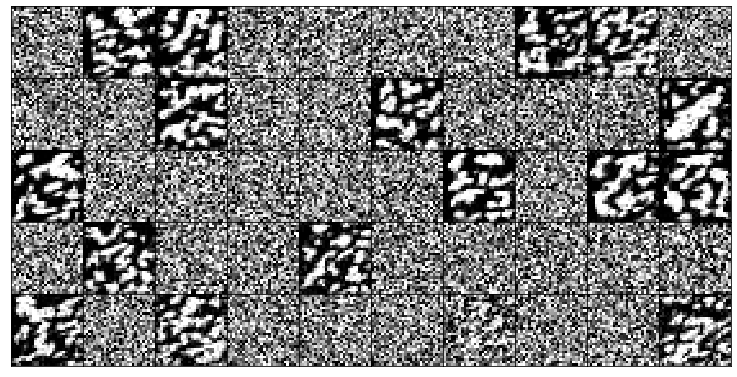

In [9]:
gs = gridspec.GridSpec(int(test_batch_size/10), 10)
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(10, 10*int(test_batch_size/10)/ 10))
for i in range(test_batch_size):
    ax = fig.add_subplot(gs[int(i/10), i%10])
    ax.imshow(images_ebm[i], cmap='gray', vmin=0, vmax=1.0)
    ax.set_xticks([])
    ax.set_yticks([])
# plt.savefig('ebm_samples.png')